## Reto March Machine Learning Mania

Otro año, otra oportunidad para predecir las sorpresas, calcular las probabilidades y poner a prueba tus habilidades de bracketología en la clasificación. En nuestra undécima competencia anual "Marcha de Aprendizaje Automático Mania", los Kagglers se unirán una vez más a los millones de aficionados que intentan predecir los resultados de los torneos de baloncesto universitario de este año. A diferencia de la mayoría de los aficionados, elegirás a los ganadores y perdedores utilizando una combinación de datos históricos de gran valor y potencia informática, mientras la verdad sobre el terreno se revela en televisión.

Se te proporcionan datos de partidos históricos de la NCAA para pronosticar los resultados de los torneos de baloncesto masculino y femenino de la División 1. Esta competencia es la edición oficial de 2025, con puntos, medallas, premios y la gloria del baloncesto en juego.

Hemos vuelto al formato de 2023, donde se realizan predicciones sobre todos los posibles enfrentamientos del torneo, evaluados mediante la puntuación Brier. Consulta la página de evaluación para obtener más detalles.

Antes del inicio de los torneos, la clasificación de esta competición reflejará únicamente las puntuaciones de 2021 a 2024. Kaggle actualizará periódicamente los resultados y volverá a puntuar una vez que comiencen los juegos de 2025.

Fuente:
[Cita:](www.kaggle.com/competitions/march-machine-learning-mania-2025/overview/citation)
 



#### Preparación del entorno

intalación de librerias

In [18]:
pip install pandas numpy scikit-learn xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

### Lectura de información CSV con los datos del torneo más relevantes



Parece que estás cargando los datos clave para el **Reto March Machine Learning Mania 2025** en Kaggle. Vamos a analizar cada uno de estos archivos y su posible utilidad en la construcción de un modelo predictivo:

---

 **1. `MTeams.csv`**  
Contiene información básica de los equipos de la NCAA (División I masculina).  
- **Columnas relevantes**:  
  - `TeamID` → Identificador único del equipo.  
  - `TeamName` → Nombre del equipo (ej: "Duke", "Kansas").  
  - Posiblemente otras como `FirstD1Season` (año de debut en División I).  

---

 **2. `MNCAATourneySeeds.csv`**  
Indica la "semilla" (posición en el bracket) de cada equipo en el torneo por año.  
- **Columnas clave**:  
  - `Season` → Año del torneo (ej: 2024).  
  - `TeamID` → Identificador del equipo.  
  - `Seed` → Semilla (ej: "W01" → Región Oeste, semilla 1).  


---

 **3. `MNCAATourneyCompactResults.csv`**  
Resultados históricos de partidos del torneo NCAA (formato compacto).  
- **Columnas importantes**:  
  - `Season`, `DayNum` → Fecha del partido.  
  - `WTeamID` (equipo ganador), `LTeamID` (equipo perdedor).  
  - `WScore`, `LScore` → Puntos anotados.  


---

 **4. `MRegularSeasonCompactResults.csv`**  
Resultados de la temporada regular (previo al torneo).  
- **Estructura similar a `TourneyCompactResults`**, pero con más partidos.  


---

 **5. `SampleSubmissionStage1.csv`**  
Formato de envío para la competencia.  
- **Estructura**:  
  - `ID` → Formato `"2025_XXXX_YYYY"` (temporada, TeamID1, TeamID2).  
  - `Pred` → Probabilidad de que TeamID1 gane a TeamID2 (debe estar entre 0 y 1).  


---

**Evaluación**

**Puntuación Brier:**

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} (p_i - y_i)^2
$$

- \( p_i \): Probabilidad predicha de que gane el equipo A.  
- \( y_i \):  
  - \( 1 \) si gana el equipo A.  
  - \( 0 \) si pierde.


In [ ]:
#Lectura de los archivos:

teams = pd.read_csv("datos/MTeams.csv")
seeds = pd.read_csv("datos/MNCAATourneySeeds.csv")
tourney_results = pd.read_csv("datos/MNCAATourneyCompactResults.csv")
season_results = pd.read_csv("datos/MRegularSeasonCompactResults.csv")
sample_submission = pd.read_csv("datos/SampleSubmissionStage1.csv")

- Cada equipo clasificado al torneo es asignado a una región (por ejemplo: West, East, Midwest, South).

- Dentro de esa región, se le asigna un número del 1 al 16, donde:

        Seed 1 = equipo más fuerte de esa región

        Seed 16 = equipo más débil

- Hay 4 regiones, por lo tanto hay cuatro equipos con seed 1, cuatro con seed 2, etc.

In [21]:
def extract_seed(seed):
    return int(seed[1:3])


seeds['Seed'] = seeds['Seed'].apply(extract_seed)

Esta función convierte los resultados históricos (partidos jugados en torneos pasados) en ejemplos que puede usar un modelo de Machine Learning, por ejemplo:



| Temporada | Team1 | Team2 | SeedDiff | Target |
| --------- | ----- | ----- | -------- | ------ |
| 2023      | 1101  | 1181  | -13      | 1      |
| 2023      | 1181  | 1101  | 13       | 0      |

- team1 es el ganador.

- team2 es el perdedor.

Se obtiene un dataset con el siguiente resultado: 

    Season: Año del partido

    Team1, Team2: IDs de los equipos

    SeedDiff: Diferencia de seeds

    Target: 1 si gana Team1, 0 si pierde

Este dataset está listo para ser usado con un modelo de clasificación como XGBoost que es el que vamos a utilizar más adelante

In [22]:
def build_matchup_features(results, seeds_df):
    features = []

    for index, row in results.iterrows():
        season = row['Season']
        team1 = row['WTeamID']
        team2 = row['LTeamID']

        # Obtener seed 
        try:
            seed1 = seeds_df[(seeds_df['Season'] == season) & (seeds_df['TeamID'] == team1)]['Seed'].values[0]
            seed2 = seeds_df[(seeds_df['Season'] == season) & (seeds_df['TeamID'] == team2)]['Seed'].values[0]
        except IndexError:
            continue 

        features.append({
            'Season': season,
            'Team1': team1,
            'Team2': team2,
            'SeedDiff': seed1 - seed2,
            'Target': 1
        })


        features.append({
            'Season': season,
            'Team1': team2,
            'Team2': team1,
            'SeedDiff': seed2 - seed1,
            'Target': 0
        })

    return pd.DataFrame(features)


**Algoritmo de XGBoost**

XGBoost es una biblioteca optimizada de potenciación de gradientes distribuida, diseñada para ser altamente eficiente , flexible y portátil . Implementa algoritmos de aprendizaje automático bajo el marco de potenciación de gradientes . XGBoost proporciona potenciación de árboles paralelos (también conocidos como GBDT, GBM) que resuelve numerosos problemas de ciencia de datos de forma rápida y precisa. El mismo código se ejecuta en los principales entornos distribuidos (Hadoop, SGE, MPI) y puede resolver problemas que superan los miles de millones de ejemplos.

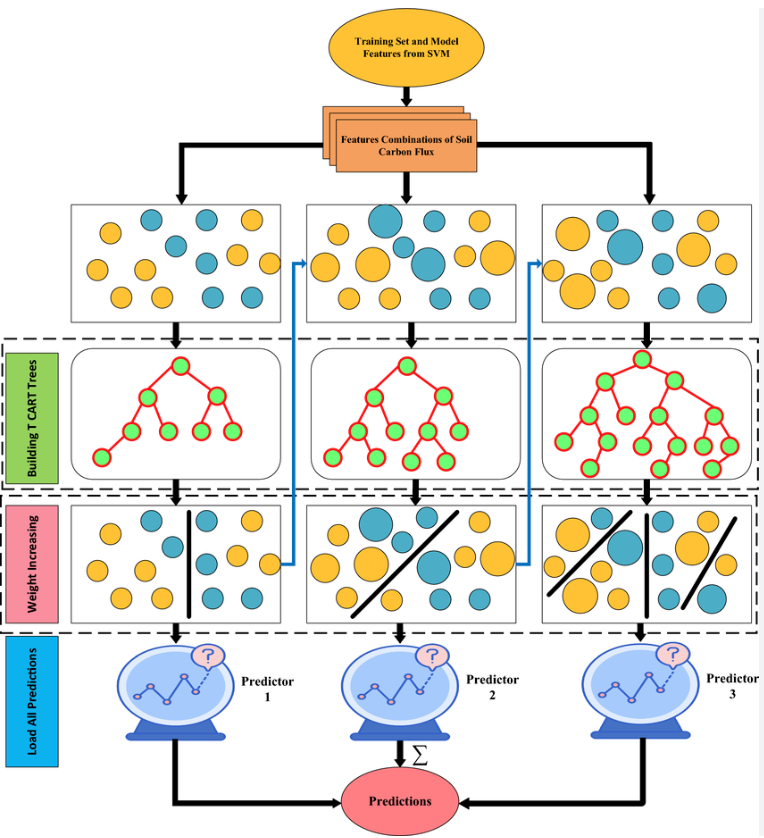

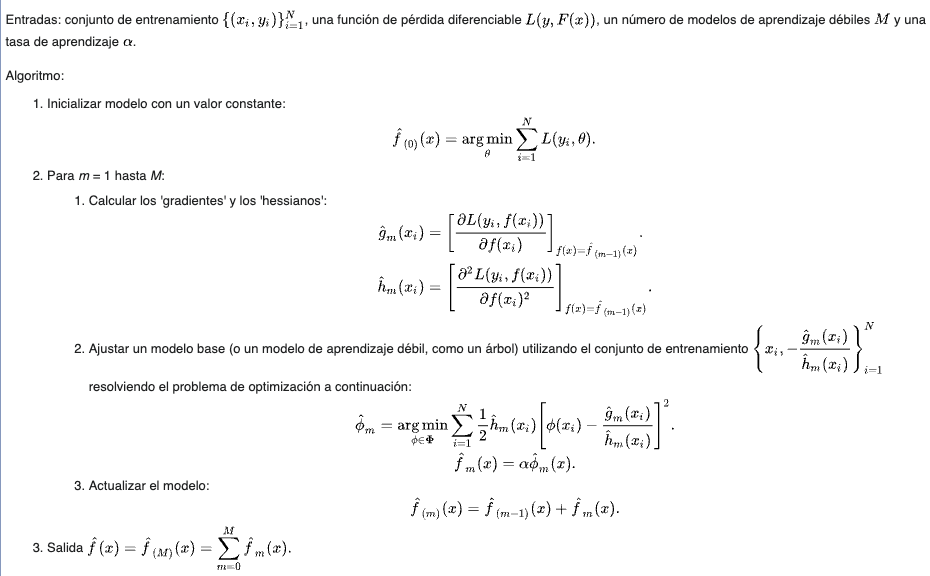

In [ ]:
train_df = build_matchup_features(tourney_results, seeds)

In [23]:
X = train_df[['SeedDiff']]
y = train_df['Target']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:31:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
val_preds = model.predict_proba(X_val)[:, 1]
print("Log loss:", log_loss(y_val, val_preds))


Log loss: 0.5514767845426286


In [27]:
def extract_ids(row_id):
    season, team1, team2 = map(int, row_id.split('_'))
    return season, team1, team2

submission = sample_submission.copy()
submission[['Season', 'Team1', 'Team2']] = submission['ID'].apply(
    lambda x: pd.Series(extract_ids(x))
)

def compute_seed_diff(row, seeds_df):
    season, t1, t2 = row['Season'], row['Team1'], row['Team2']
    try:
        seed1 = seeds_df[(seeds_df['Season'] == season) & (seeds_df['TeamID'] == t1)]['Seed'].values[0]
        seed2 = seeds_df[(seeds_df['Season'] == season) & (seeds_df['TeamID'] == t2)]['Seed'].values[0]
        return seed1 - seed2
    except IndexError:
        return 0  

submission['SeedDiff'] = submission.apply(lambda row: compute_seed_diff(row, seeds), axis=1)


In [28]:
submission['Pred'] = model.predict_proba(submission[['SeedDiff']])[:, 1]

#### Almacenamiento de los datos obtenidos del modelo

In [29]:
submission[['ID', 'Pred']].to_csv("submission.csv", index=False)

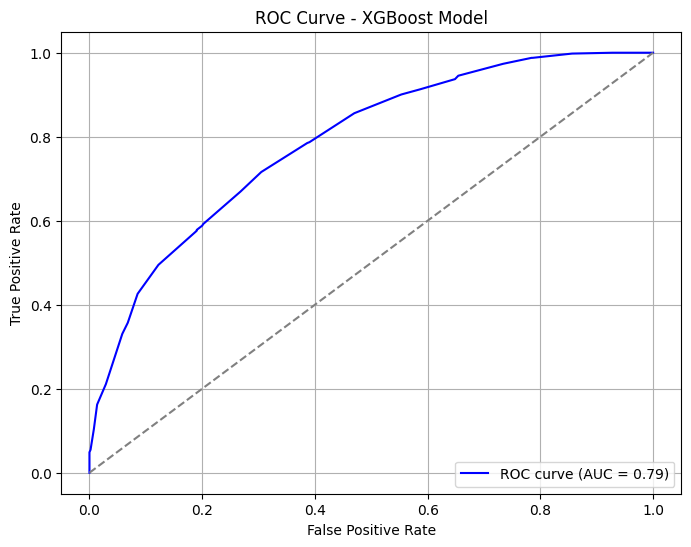

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades de clase positiva (ganar)
y_probs = model.predict_proba(X_val)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Grafica
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


El gráfico ROC del modelo XGBoost muestra una AUC de 0.79, lo que indica una buena capacidad predictiva para distinguir entre partidos ganados y perdidos. El modelo tiene un 79% de probabilidad de asignar una mayor probabilidad de victoria al equipo que efectivamente ganó, en comparación con uno que perdió, lo cual es significativamente mejor que el azar (AUC = 0.5). Aunque los resultados son aceptables, aún hay margen de mejora incorporando variables adicionales o refinando el modelo para aumentar su precisión.

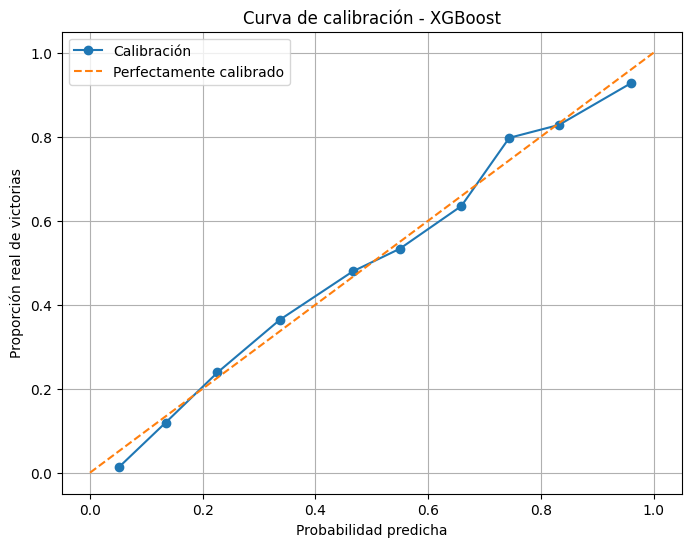

In [31]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, y_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibración')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectamente calibrado')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Proporción real de victorias')
plt.title('Curva de calibración - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


La curva de calibración del modelo XGBoost muestra que las probabilidades predichas están bien calibradas, ya que la línea azul sigue de cerca la línea diagonal naranja, que representa una calibración perfecta. Esto significa que, por ejemplo, cuando el modelo asigna una probabilidad de victoria del 70%, el equipo gana aproximadamente el 70% de las veces. Aunque hay ligeras desviaciones en algunos tramos, en general el modelo predice probabilidades buenas.


### Implementación del archivo MRegularSeasonDetailedResults para ver si pouedo mejorar el modelo

In [ ]:
# Cargar datos detallados
detailed_results = pd.read_csv("datos/MRegularSeasonDetailedResults.csv")

def process_detailed_data(df):
    # Calcular estadísticas para el equipo ganador (W) y perdedor (L)
    for prefix in ['W', 'L']:
        #El porcentaje de rebotes ofensivos que un equipo captura respecto a los disponibles cuando ataca, 
        # Un valor alto (ej: >0.3) indica que el equipo es bueno recuperando rebotes en ataque
        df[f'{prefix}ORebPct'] = df[f'{prefix}OR'] / (df[f'{prefix}OR'] + df[f'{opp_prefix(prefix)}DR'])
        #La eficiencia de tiros de campo, dando más peso a los triples. Un eFG% de 0.55 o más es muy bueno
        df[f'{prefix}eFG%'] = (df[f'{prefix}FGM'] + 0.5 * df[f'{prefix}FG3M']) / df[f'{prefix}FGA']
        #La frecuencia de pérdidas (turnovers) por posesion Es un factor de corrección para estimar posesiones (no todos los tiros libres terminan una posesión).
        df[f'{prefix}TOVPct'] = df[f'{prefix}TO'] / (df[f'{prefix}FGA'] + 0.44 * df[f'{prefix}FTA'] + df[f'{prefix}TO'])
    
    return df

def opp_prefix(prefix):
    return 'L' if prefix == 'W' else 'W'

detailed_results = process_detailed_data(detailed_results)

In [47]:
def create_team_stats(detailed_results):
    # Agrupar por equipo y temporada
    team_stats = []
    
    for (season, team_id), group in detailed_results.groupby(['Season', 'WTeamID']):
        wins = group[group['WTeamID'] == team_id]
        team_stats.append({
            'Season': season,
            'TeamID': team_id,
            'WinPct': len(wins) / len(group),
            'AvgPoints': wins['WScore'].mean(),
            'AvgOReb': wins['WOR'].mean(),
            'AvgTO': wins['WTO'].mean(),
            'eFG%': wins['WeFG%'].mean(),
            'ORebPct': wins['WORebPct'].mean()
        })
    
    return pd.DataFrame(team_stats)

team_stats = create_team_stats(detailed_results)

Ejemplo de una fila de la anterior función:

{
    'Season': 2023, 
    'TeamID': 1234, 
    'WinPct': 0.80, 
    'AvgPoints': 78.5, 
    'AvgOReb': 10.2, 
    'AvgTO': 9.1, 
    'eFG%': 0.55, 
    'ORebPct': 0.28
}

El equipo 1234 en 2023 ganó el 80% de sus partidos, con 78.5 puntos promedio por juego y alta eficiencia en tiros (55% eFG%).

Ahora, la función build_advanced_features genera un dataset de entrenamiento para el modelo comparando estadísticas históricas de equipos en el torneo (tourney_results), calculando diferencias clave (porcentaje de victorias, eficiencia de tiros, rebotes ofensivos y puntos promedio) entre el ganador (Team1) y el perdedor (Team2) por partido, y añadiendo cada enfrentamiento dos veces (con los equipos invertidos y el Target cambiado a 0) para balancear los datos. 

**Balancear** los datos es crucial porque evita que el modelo aprenda sesgos hacia la clase mayoritaria (partidos donde un equipo gana sobre otro), lo que perjudica la capacidad para predecir correctamente ambas clases que son victorias y/o derrotas

In [48]:
def build_advanced_features(tourney_results, team_stats):
    features = []
    
    for _, row in tourney_results.iterrows():
        season = row['Season']
        team1 = row['WTeamID']
        team2 = row['LTeamID']
        
        # Obtener stats para ambos equipos
        stats1 = team_stats[(team_stats['Season'] == season) & (team_stats['TeamID'] == team1)]
        stats2 = team_stats[(team_stats['Season'] == season) & (team_stats['TeamID'] == team2)]
        
        if len(stats1) == 0 or len(stats2) == 0:
            continue
            
        stats1 = stats1.iloc[0]
        stats2 = stats2.iloc[0]
        

        features.append({
            'Season': season,
            'Team1': team1,
            'Team2': team2,
            'WinPctDiff': stats1['WinPct'] - stats2['WinPct'],
            'eFG%Diff': stats1['eFG%'] - stats2['eFG%'], # (Eficiencia tiros Equipo1) - (Eficiencia tiros Equipo2)
            'ORebPctDiff': stats1['ORebPct'] - stats2['ORebPct'], # (Rebotes ofensivos Equipo1) - (Rebotes ofensivos Equipo2)
            'AvgPointsDiff': stats1['AvgPoints'] - stats2['AvgPoints'], # (Puntos por juego Equipo1) - (Puntos por juego Equipo2)
            'Target': 1 # 1 si Equipo1 gana, 0 si pierde (etiqueta)
        })
        
        # Versión inversa para balancear para evitar sesgos por equipos altamente ganadores en la historia pero que ahora no puede que ganen
        features.append({
            'Season': season,
            'Team1': team2,
            'Team2': team1,
            'WinPctDiff': stats2['WinPct'] - stats1['WinPct'],
            'eFG%Diff': stats2['eFG%'] - stats1['eFG%'],
            'ORebPctDiff': stats2['ORebPct'] - stats1['ORebPct'],
            'AvgPointsDiff': stats2['AvgPoints'] - stats1['AvgPoints'],
            'Target': 0
        })
    
    return pd.DataFrame(features)

train_df = build_advanced_features(tourney_results, team_stats)

In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


X = train_df.drop(['Season', 'Team1', 'Team2', 'Target'], axis=1)
y = train_df['Target']

# Dividir en train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Parámetros optimizados
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1.0,
    'seed': 42,
    'n_estimators': 5000
}

# Entrenamiento
model = xgb.XGBClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=10
)

# Evaluación
y_pred = model.predict_proba(X_val)[:, 1]
print(f"Log Loss: {log_loss(y_val, y_pred):.4f}")

[0]	validation_0-logloss:0.69288
[10]	validation_0-logloss:0.69029
[20]	validation_0-logloss:0.68762
[30]	validation_0-logloss:0.68548
[40]	validation_0-logloss:0.68448
[50]	validation_0-logloss:0.68302
[60]	validation_0-logloss:0.68242
[70]	validation_0-logloss:0.68205
[80]	validation_0-logloss:0.68214
[90]	validation_0-logloss:0.68172
[100]	validation_0-logloss:0.68148
[110]	validation_0-logloss:0.68097
[120]	validation_0-logloss:0.68126
[130]	validation_0-logloss:0.68130
[140]	validation_0-logloss:0.68144
[150]	validation_0-logloss:0.68163
[160]	validation_0-logloss:0.68179
[170]	validation_0-logloss:0.68260
[180]	validation_0-logloss:0.68284
[190]	validation_0-logloss:0.68372
[200]	validation_0-logloss:0.68399
[210]	validation_0-logloss:0.68476
[220]	validation_0-logloss:0.68543
[230]	validation_0-logloss:0.68599
[240]	validation_0-logloss:0.68661
[250]	validation_0-logloss:0.68728
[260]	validation_0-logloss:0.68801
[270]	validation_0-logloss:0.68865
[280]	validation_0-logloss:0.68

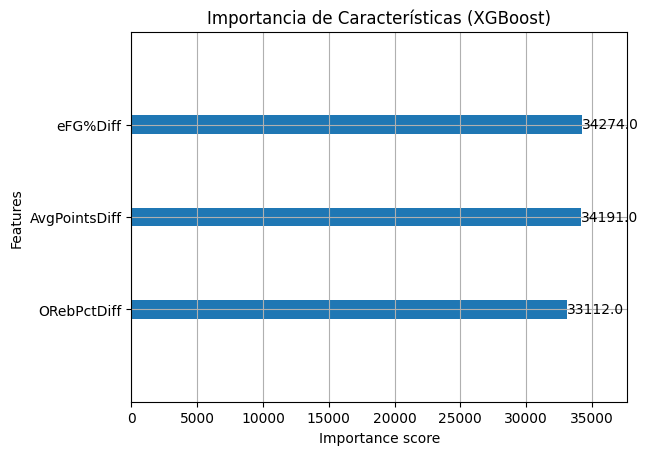

In [55]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, importance_type='weight', max_num_features=10)  
plt.title('Importancia de Características (XGBoost)')
plt.show()

preparación del archivo CSV de salida para mostrar la estimación de los equipos 

In [57]:
def prepare_submission_data(sample_sub, team_stats, seeds):
    submission = sample_sub.copy()
    submission['Season'] = submission['ID'].str.split('_').str[0].astype(int)
    submission['Team1'] = submission['ID'].str.split('_').str[1].astype(int)
    submission['Team2'] = submission['ID'].str.split('_').str[2].astype(int)
    
    features = []
    
    for _, row in submission.iterrows():
        season = row['Season']
        team1 = row['Team1']
        team2 = row['Team2']
        
        stats1 = team_stats[(team_stats['Season'] == season) & (team_stats['TeamID'] == team1)]
        stats2 = team_stats[(team_stats['Season'] == season) & (team_stats['TeamID'] == team2)]
        
        if len(stats1) == 0 or len(stats2) == 0:
            features.append([0] * (len(X.columns)))
            continue
            
        stats1 = stats1.iloc[0]
        stats2 = stats2.iloc[0]
        
        features.append([
            stats1['WinPct'] - stats2['WinPct'],
            stats1['eFG%'] - stats2['eFG%'],
            stats1['ORebPct'] - stats2['ORebPct'],
            stats1['AvgPoints'] - stats2['AvgPoints']
        ])
    
    return pd.DataFrame(features, columns=X.columns)

submission_features = prepare_submission_data(sample_submission, team_stats, seeds)
submission['Pred'] = model.predict_proba(submission_features)[:, 1]
submission.to_csv("advanced_xgb_submission.csv", index=False)

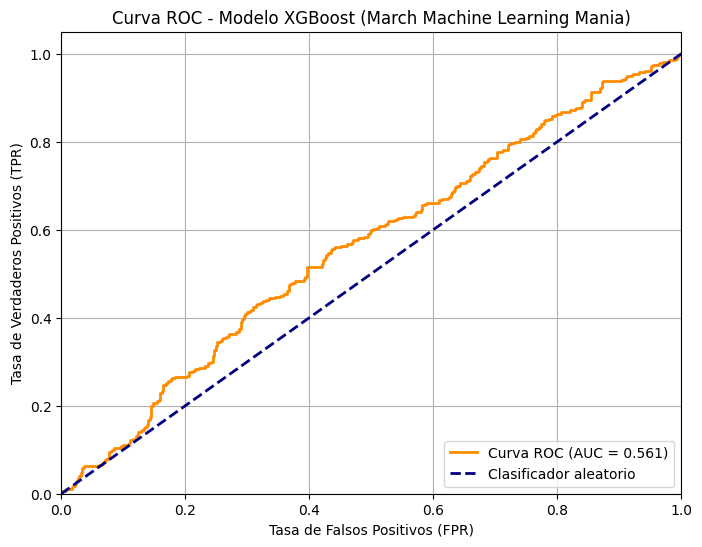

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y validación
X = train_df.drop(['Season', 'Team1', 'Team2', 'Target'], axis=1)
y = train_df['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

#modelo XGBoost 
model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.01,
    max_depth=6,
    n_estimators=1000,
    eval_metric='logloss'
)
model.fit(X_train, y_train)


y_pred_proba = model.predict_proba(X_val)[:, 1]  

# curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo XGBoost (March Machine Learning Mania)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()